#reema

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The first step is to load the dataset. As our dataset is represented as a text file with the format (sentence;emotion), we use the parameter sep=";" as a separator to create a table containing two columns: text for the sentences and label for the emotions. Then, we read the first five elements to ensure that the data has been loaded properly.

In [2]:
df = pd.read_csv("train.txt", sep=";", names=["text", "label"])
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


we using (.info) to get the dataset description:
1- number of features (columns)
2- number of observations (rows)
3- data types


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


from the result we notice:
1- there are 2 columns (0:text and 1:label)
2- there are  16K rows (0-15999)
3- Both coulmns have 16000 non-null entries implies that no missing data
4- Both are of type object (object in pandas means text type) 

in this step we have to anlayze the target class, in our case the label column
we use:
1- df['label'].nunique() to count how many diffren labels 
2- df['label'].unique() list all unique emotion classes
3- df['label'].value_counts() to know how many text for each label

In [4]:
print("there are",df['label'].nunique(),"diffrent classes (emotions):\n",df['label'].unique()) 

there are 6 diffrent classes (emotions):
 ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [5]:
df['label'].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

From the results, we observe that:
1- we have six different emotion classes.
2- The dataset is imbalanced, as some emotions significantly outnumber others (e.g., joy vs surprise).

Regarding the imbalanced dataset, we decided to remove the surprise emotion, which had very few samples.
After that, we applied under-sampling to the remaining classes to ensure a more balanced distribution of emotions and to prevent the model from being biased toward the majority classes.

In [6]:
df_preprocessing  = df[df["label"] != "surprise"]
print("there are",df_preprocessing['label'].nunique(),"diffrent classes (emotions):\n",df_preprocessing['label'].unique()) 

there are 5 diffrent classes (emotions):
 ['sadness' 'anger' 'love' 'fear' 'joy']


In [7]:
targets = ["joy", "sadness"]
parts = []
for label, group in df_preprocessing.groupby("label"):
    if label in targets:
        group = group.sample(frac=0.5, random_state=42)
    parts.append(group)
df_undersampled = pd.concat(parts, ignore_index=True)
df_undersampled['label'].value_counts()

label
joy        2681
sadness    2333
anger      2159
fear       1937
love       1304
Name: count, dtype: int64

After dropping the "surprise" label and reducing the highest two labels by a factor of 0.50, the data became more balanced across all emotion classes.

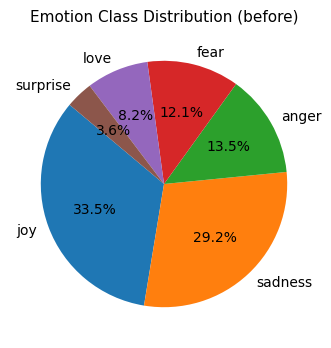

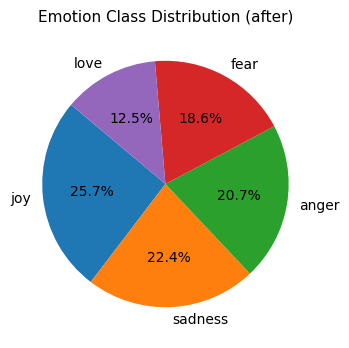

In [8]:
emotionNum = df['label'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(emotionNum,
        labels=emotionNum.index,
        autopct='%1.1f%%',
        startangle=140
        )
plt.title('Emotion Class Distribution (before)', fontsize=11)

emotionNum = df_undersampled['label'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(emotionNum,
        labels=emotionNum.index,
        autopct='%1.1f%%',
        startangle=140
        )
plt.title('Emotion Class Distribution (after)', fontsize=11)
plt.show()

The two figures illustrate the class distribution before and after balancing.
Checking the dataset information using .info(). 

In [9]:
df_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10414 entries, 0 to 10413
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10414 non-null  object
 1   label   10414 non-null  object
dtypes: object(2)
memory usage: 162.8+ KB


Dataset reduced from 16K to 10K records, achieving acceptable class balance, then stored in a new variable named dataset for further processing

In [10]:
dataset = df_undersampled.copy()

After this point we will start the text preprocessing 

We have added two new columns:
char: counts the number of characters in each text,
word: counts the number of words in each text.
Then, describe() was used to show summary statistics.

In [11]:
dataset['char'] = dataset['text'].astype(str).str.len()
dataset['word'] = dataset['text'].astype(str).str.split().apply(len)
dataset.describe()

,char,word
count,10414.000000,10414.000000
mean,97.082773,19.190417
std,56.076974,11.027485
min,9.000000,2.000000
25%,54.000000,11.000000
50%,86.000000,17.000000
75%,129.000000,25.000000
max,299.000000,64.000000


On average, each text has 97 characters and 19 words, most texts range between 54-129 characters and 11–25 words, ,the shortest text has 9characters  2 words and the longest has 299 characters and 64 words. 

In [12]:
desc_summary = (
    dataset.groupby('label')[['char', 'word']]
    .agg(['mean', 'std', 'min', 'max','var'])
    .round(2))
desc_summary


char                            word                       
           mean    std min  max      var   mean    std min max     var
label                                                                 
anger     96.91  57.68   9  298  3326.69  19.23  11.43   2  62  130.57
fear      96.12  55.19   9  296  3045.71  18.84  10.89   2  60  118.60
joy       97.89  54.85   9  296  3008.65  19.32  10.71   2  64  114.69
love     104.03  55.15  13  299  3041.07  20.70  10.83   3  63  117.24
sadness   93.23  56.87  12  299  3234.36  18.45  11.16   3  61  124.45

The mean indicates that love texts are generally longer and more detailed, while sadness texts are the shortest and most direct.
The standard deviation and variance reveal that anger and sadness have greater variation in length, meaning people express these emotions in very different ways some briefly, others with longer reflections.

The charts show the average number of words and characters for each emotion label

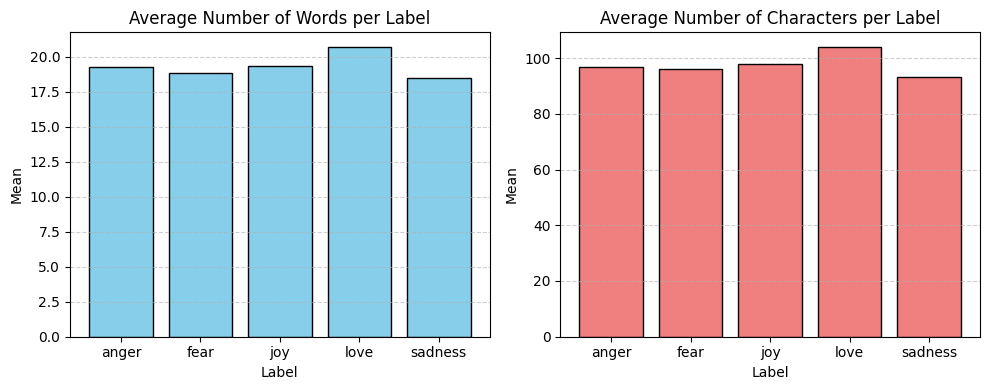

In [13]:
labels = desc_summary.index 
avg_words = desc_summary['word']['mean']
avg_chars = desc_summary['char']['mean']
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.bar(labels, avg_words, color='skyblue', edgecolor='black')
plt.title('Average Number of Words per Label')
plt.xlabel('Label')
plt.ylabel('Mean')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.bar(labels, avg_chars, color='lightcoral', edgecolor='black')
plt.title('Average Number of Characters per Label')
plt.xlabel('Label')
plt.ylabel('Mean')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

We will verify whether each text contains only lowercase alphabetic characters (spaces are accepted for further actions).

In [14]:
check = dataset['text'].apply(lambda x: x.replace(" ", "").isalpha() and x.lower() == x).all()

if check:
    print("valid")
else:
    print("invalid")


valid


Since its valid we will start with the next step

Tokenizition:"Step in NLP text preprocessing where text is segmented into smaller units, typically words or subwords, known as tokens."
This is an important step to make the text data in a machine-readable format.

In [15]:
dataset['tokens'] = dataset['text'].apply(nltk.word_tokenize)
dataset[['text', 'tokens']].head()

,text,tokens
0,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, a, minute, to, post, i, feel, g..."
1,i am feeling grouchy,"[i, am, feeling, grouchy]"
2,i think it s the easiest time of year to feel ...,"[i, think, it, s, the, easiest, time, of, year..."
3,i feel irritated and rejected without anyone d...,"[i, feel, irritated, and, rejected, without, a..."
4,i already feel like i fucked up though because...,"[i, already, feel, like, i, fucked, up, though..."


Removing stop words: "Is crucial to enhance the quality and efficiency of analysis. Stop words are common words like "the," "is," and "and," which appear frequently in text but carry little semantic meaning"

In [16]:
stop_words = set(stopwords.words('english'))
dataset['tokens_no_stop'] = dataset['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
display(dataset[['tokens', 'tokens_no_stop']].head(3))
display(dataset[['tokens', 'tokens_no_stop']].tail(3))

,tokens,tokens_no_stop
0,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]"
1,"[i, am, feeling, grouchy]","[feeling, grouchy]"
2,"[i, think, it, s, the, easiest, time, of, year...","[think, easiest, time, year, feel, dissatisfied]"


,tokens,tokens_no_stop
10411,"[im, so, happy, that, he, loves, my, husband, ...","[im, happy, loves, husband, feels, doesnt, nee..."
10412,"[i, was, trying, to, think, of, anywhere, else...","[trying, think, anywhere, else, ive, made, fee..."
10413,"[i, was, pleasantly, surprised, to, read, that...","[pleasantly, surprised, read, susceptible, fal..."


We noticed that some words like im are still present because the original dataset did not contain apostrophes. For example, I'm became im, didn't became didnt, and I've became ive.
Due to this issue, we decided to create a list of common contraction forms that might appear this way and remove them to make the text cleaner.

In [17]:
extra_stops = {
    'im', 'ive', 'dont', 'youre', 'hes', 'shes', 'wasnt', 'cant', 'couldnt',
    'didnt', 'doesnt', 'isnt', 'shouldnt', 'wouldnt', 'havent', 'hasnt',
    'hadnt', 'wont', 'mightnt', 'mustnt'}

dataset['tokens_no_stop'] = dataset['tokens_no_stop'].apply(
    lambda tokens: [word for word in tokens if word not in extra_stops]
)
display(dataset[['tokens', 'tokens_no_stop']].head(3))
display(dataset[['tokens', 'tokens_no_stop']].tail(3))

,tokens,tokens_no_stop
0,"[im, grabbing, a, minute, to, post, i, feel, g...","[grabbing, minute, post, feel, greedy, wrong]"
1,"[i, am, feeling, grouchy]","[feeling, grouchy]"
2,"[i, think, it, s, the, easiest, time, of, year...","[think, easiest, time, year, feel, dissatisfied]"


,tokens,tokens_no_stop
10411,"[im, so, happy, that, he, loves, my, husband, ...","[happy, loves, husband, feels, need, worry, tr..."
10412,"[i, was, trying, to, think, of, anywhere, else...","[trying, think, anywhere, else, made, feel, aw..."
10413,"[i, was, pleasantly, surprised, to, read, that...","[pleasantly, surprised, read, susceptible, fal..."


Lemmatization: "Is performed in NLP text preprocessing to reduce words to their base or dictionary form (lemma), enhancing consistency and simplifying analysis". 

In [18]:
lemmatizer = WordNetLemmatizer()
dataset['tokens_lemmatized'] = dataset['tokens_no_stop'].apply(
    lambda tokens: [lemmatizer.lemmatize(word, pos='v') for word in tokens])
dataset[['tokens', 'tokens_lemmatized']].head()

,tokens,tokens_lemmatized
0,"[im, grabbing, a, minute, to, post, i, feel, g...","[grab, minute, post, feel, greedy, wrong]"
1,"[i, am, feeling, grouchy]","[feel, grouchy]"
2,"[i, think, it, s, the, easiest, time, of, year...","[think, easiest, time, year, feel, dissatisfy]"
3,"[i, feel, irritated, and, rejected, without, a...","[feel, irritate, reject, without, anyone, anyt..."
4,"[i, already, feel, like, i, fucked, up, though...","[already, feel, like, fuck, though, usually, e..."


In [19]:
final_dataset= dataset[['label','text', 'tokens_lemmatized']].rename(columns={'tokens_lemmatized': 'tokens'})
display(final_dataset.head(3))
display(final_dataset.tail(3))

,label,text,tokens
0,anger,im grabbing a minute to post i feel greedy wrong,"[grab, minute, post, feel, greedy, wrong]"
1,anger,i am feeling grouchy,"[feel, grouchy]"
2,anger,i think it s the easiest time of year to feel ...,"[think, easiest, time, year, feel, dissatisfy]"


,label,text,tokens
10411,sadness,im so happy that he loves my husband and feels...,"[happy, love, husband, feel, need, worry, trou..."
10412,sadness,i was trying to think of anywhere else ive bee...,"[try, think, anywhere, else, make, feel, awful..."
10413,sadness,i was pleasantly surprised to read that i was ...,"[pleasantly, surprise, read, susceptible, fall..."


Calling to ensure the result before saving in train file.

In [20]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10414 entries, 0 to 10413
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10414 non-null  object
 1   text    10414 non-null  object
 2   tokens  10414 non-null  object
dtypes: object(3)
memory usage: 244.2+ KB


In [21]:
final_dataset.to_csv('final_dataset.txt', index=True, encoding='utf-8')